In [1]:
#Библиотеки для работы с данными
import numpy as np
import pandas as pd
#Для построения и работы с графиками
import matplotlib.pyplot as plt
import plotly.express as px
#Для работы с моделями
import keras
import tensorflow as tf
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.efficientnet_v2 import EfficientNetV2B1, preprocess_input
from sklearn.model_selection import KFold
#Для оценки результатов обучения модели
from livelossplot.tf_keras import PlotLossesCallback
#Для работы с изображениями
import cv2
from PIL import Image
#Для взаимодействия с ОС
import os

2024-09-26 06:09:30.791847: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-26 06:09:30.791880: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-26 06:09:30.791892: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-26 06:09:30.795718: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Подтянем директории с файлами для обучения
#Тренировочная часть
train_dir = './data/emotion_recog_data/train'
#Публичная тестовая часть датасета
test_dir = './data/emotion_recog_data/test'

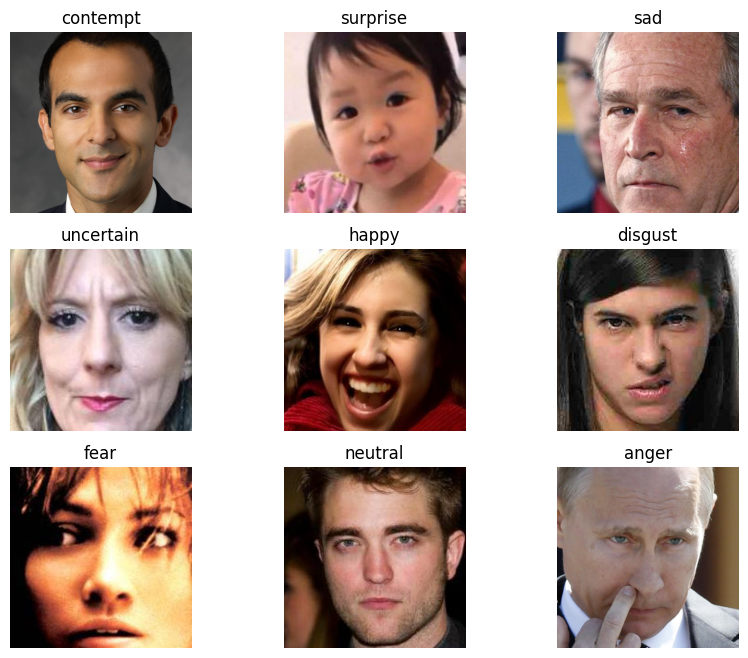

In [3]:
#Выведщем по одному изображения каждой эмоции
fig = plt.figure(figsize=(10, 8)) 
#Определим к-во столбцов и строк для отображения фотографий:
rows = 3
columns = 3

emo_cnt = 0
for dir_ in os.listdir(train_dir):#для каждой папки/эмоции
    emo_cnt+=1
    fig.add_subplot(rows, columns, emo_cnt) #добавим изображение эмоции на график
    im = Image.open(os.path.join(train_dir, dir_, '9.jpg'))
    emo_img = np.asarray(im)
    plt.imshow(emo_img) 
    plt.axis('off') 
    plt.title(dir_)

In [4]:
# Похоже, что изображения имеют разный размер. Проверим это на практике.
sizes = [] #пустой список для сбора размеров

# Проходимся по всем директориям папки с тренировочными изображениями
for dirpath, dirnames, filenames in os.walk(train_dir):
    for filename in filenames:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')): #проверка того, что файл является изображением
            # Пропишем путь к файлу
            file_path = os.path.join(dirpath, filename)
            # Загрузим изображение
            img = Image.open(file_path)
            # Сохраним его параметры в список
            sizes.append(img.size)
            
#Теперь посчитаем к-во изображений каждого размера
s_count = pd.Series(sizes).value_counts()

In [5]:
#Выведем, что получилось
s_count.head(10)

(256, 256)    294
(186, 186)    283
(183, 183)    283
(188, 188)    276
(192, 192)    267
(193, 193)    265
(196, 196)    260
(203, 203)    259
(179, 179)    256
(197, 197)    250
Name: count, dtype: int64

**Выводы:** 
1) Размер у изображений, как заметно выше, совершенно разный при сходной форме (все фотографии были обрезаны до квадрата). С этим, в принципе, можно работать при условии приведения всех изображений к одному размеру для подачи в модель.
2) Не все изображения эмоций являются репрезентативными:
* есть картинки с посторонними предметами и объектами, закрывающими в какой-то степени лицо; 
* присутствуют в выборке изображения низкого качества (слишком темные и размытые);
* в связи с общей сложностью задачи определения эмоций для обычного человека, присутствуют также фотографии, на которых эмоция не совсем однозначна и трудно интерпретируема. 

*Примечание: номер изображения для вывода выше подбирала, чтобы этих недочетов было как можно меньше. Как мне кажется, на этих фотографиях лица более-менее четкие и эмоции соответствуют проставленному ярлыку.*

In [6]:
# Проходимся по всем директориям папки с тренировочными изображениями
for dirpath, dirnames, filenames in os.walk(train_dir):
    for filename in filenames:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')): #проверка того, что файл является изображением
            # Пропишем путь к файлу
            file_path = os.path.join(dirpath, filename)
            # Загрузим изображение
            img = Image.open(file_path)
            # Сохраним его параметры в список
            sizes.append(img.size)
#Теперь посчитаем к-во изображений каждого размера
s_count = pd.Series(sizes).value_counts()

In [7]:
#Посмотрим также на распределение количества изображений по категориям (эмоциям)

cat_list = []
count_list = []
for dir_ in os.listdir(train_dir):
    count = 0
    for f in os.listdir(train_dir+ "/" + dir_ + "/"):
        if f.lower().endswith(('.png', '.jpg', '.jpeg')):#отберём только изображения
            count += 1
    cat_list.append(dir_)
    count_list.append(count)
#     print(f"{dir_} has {count} number of images")
counts_df = pd.DataFrame({'emotion': cat_list,
     'images_count': count_list
    })
counts_df.sort_values(by=['emotion'], inplace = True)

In [8]:
#Всего изображений:
sum(counts_df['images_count'])

50047

Настроим параметры отображения графика и выведем его на экран:

In [9]:
CLASS_LABELS_EMOJIS = ["😠", "😕" , "🤢","😨" , "😊" , "😐 ", "☹️" , "😲","🤔" ]

In [10]:
fig = px.bar(x = CLASS_LABELS_EMOJIS,
             y = counts_df['images_count'] , 
             color = counts_df['emotion'],
             #определим цвета для каждой эмоции
             color_discrete_map={
                'anger': 'firebrick',
                'contempt': 'darkmagenta',
                'disgust':'olivedrab',
                'fear':'dimgray',
                'happy':'gold',
                'neutral':'lightblue',
                'sad':'navy',
                'surprise':'mediumvioletred',
                'uncertain':'tan'
            },
             template='presentation') 
fig.update_xaxes(title="Emotions")
fig.update_xaxes(tickfont_size =20)
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True, legend_title_text='Named emotions',
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
               
)
fig.show()

**Вывод:** Больше всего в нашем сете изображений сердитых лиц, на втором и третьем местах - нейтральные и грустные лица. Меньше всего изображений с лицами, изображающими презрение и отвращение. Это означает, что обученная на этих данных модель скорее всего будет лучше выявлять такие эмоции, как злость и печаль, а с теми, что на последних местах, справится хуже.

Теперь можно заняться подготовкой данных для подачи в модель. Сделаем это с помощью класса ImageDataGenerator.

Через него зададим следующие параметры предобработки и преоразования изображений для подачи в модель:

* horizontal_flip - случайное отражение по горизонтали
* rotation_range - максимальный угол поворота
* width_shift_range - смещение ширины по горизонтали до заданного процента
* height_shift_range - смещение высоты изображения по вертикали до заданного процента
* zoom_range - картинка будет увеличена или уменьшена не более чем на заданный процент
* rescale - масштабирование изображения, в нашем случае 1/255, т.е. до значений в пределах от 0 до 1 (упрощает модели работу)
* validation_split  - выделим долю картинок для валидации
* preprocessing_function - дополнительная функция для предобработки в соответствии с видом модели

In [11]:
BATCH_SIZE = 100
IMG_SHAPE  = 240


#Обучение и валидация:
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   rotation_range=40,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2, preprocessing_function=preprocess_input)

#Тестирование результатов (здесь нужно применить только rescale и preprocess):
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  preprocessing_function=preprocess_input)

#Теперь сгенерируем датасет на основе заданных ранее параметров:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_SHAPE ,IMG_SHAPE),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = val_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_SHAPE ,IMG_SHAPE),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = './data/emotion_recog_data/',
                                                    target_size = (IMG_SHAPE ,IMG_SHAPE),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    seed = 12,
                                                    classes=['test']
                                                  )

Found 40040 images belonging to 9 classes.
Found 10007 images belonging to 9 classes.
Found 5000 images belonging to 1 classes.


Уже по предварительной обработке изображений можно заметить, что для обучения уже была выбрана конкретная модель. Использование предварительно обученной модели является, как мне кажется, более эффективным подходом по сравнению с построением модели с нуля (особенно когда нет обширного опыта работы с подобными моделями).

ResNet-50 — это предварительно обученная модель глубокого обучения для классификации изображений, принадлежащая к классу так называемых сверточных нейронных сетей (CNN или ConvNet). Вышеназванный класс глубоких нейронных сетей, как показывает практика, наиболее часто применяется специалистами в сфере машинного обучения для анализа визуальных изображений. ResNet-50 имеет глубину 50 слоев (откуда, собственно, и берется название) и позволяет воспользоваться весами, полученными в ходе обучения данной модели на миллионе изображений из 1000 категорий базы данных ImageNet. Кроме того, модель имеет более 25 миллионов обучаемых параметров, что указывает на глубокую и хорошо проработанную архитектуру, которая делает ее оптимальной для задачи распознавания изображений.  

Конечно, существуют и другие предварительно обученные глубокие модели. В ходе подготовки и изучения различных статей по тематике классификации изображений мною были рассмотрены и изучены многие из них, в результате чего был отобран список моделей, которые можно было бы использовать для нашей конкретной задачи. Это, собственно, ResNet-50 (и 50V2, который мы будем использовать далее), Xception, InceptionV3, семейство моделей DenseNet и EfficientNet(V1 И V2). Данные архитектуры отличаются высоким уровнем точности классификации изображений и неплохой скоростью инференса[1]. 

Сначала был соблазн попробовать сразу "наилучшую" и наисвежайшую из них - EfficientNetV2, но ряд научных статей уговорил меня попробовать для начала ResNet-50. Согласно мнению многих специалистов в области машинного обучения ResNet-50 отличается отличной обобщающей способностью с сравнительно небольшим количеством ошибок в задачах распознавания изображений. При определенных условиях модель может работать даже лучше своих более новых собратьев. Так в одной из статей [2], автором было рассмотрено несколько популярных архитектур в рамках задачи классификации изображений МРТ головного мозга для определения наличия различного вида опухолей (или отсутствия паталогий как таковых). В ходе обучения на неаугментированном датасете наиболее точной оказалась модель EfficientNet-B4, в то время как легкая аугментация исходных данных привела к уверенной победе ResNet-50.

Разница между Resnet и ResNetV2 заключается в структуре их отдельных строительных блоков. В ResNetV2 пакетная нормализация (Batch Normalization) и функция активации ReLU предшествуют слоям свертки (авторы называют это пре-активацией, англ. pre-activation), в отличие от ResNetV1, где нормализация и активация ReLU применяются после слоев свертки (соответственно, пост-активация или post-activation). Если говорить простым языком и не скатываться к многочисленным формулам [3], подход pre-activation, реализуемый в обновленной версии архитектуры позволяет сохранить в ходе обучения больше информации об исходном изображении (препятсвует частичному искажению данных).

Источники:
1. https://keras.io/api/applications/
2. https://medium.com/@enrico.randellini/image-classification-resnet-vs-efficientnet-vs-efficientnet-v2-vs-compact-convolutional-c205838bbf49
3. https://medium.com/deepreview/review-of-identity-mappings-in-deep-residual-networks-ad6533452f33

In [12]:
IMG_SHAPE = (240, 240, 3)
# базовая модель -- EfficientnetV2B1
base_model = EfficientNetV2B1(input_shape= IMG_SHAPE, include_top=False, weights='imagenet')

base_model.trainable = False # замораживаем всю базовую модель
base_model.summary()

2024-09-26 06:09:45.857692: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-26 06:09:45.877550: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-26 06:09:45.877578: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-26 06:09:45.878931: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-26 06:09:45.878958: I tensorflow/compile

Model: "efficientnetv2-b1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 240, 240, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 240, 240, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 240, 240, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 120, 120, 32)         864       ['normalizatio

                                                                                                  
 block2c_expand_activation   (None, 60, 60, 128)          0         ['block2c_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block2c_project_conv (Conv  (None, 60, 60, 32)           4096      ['block2c_expand_activation[0]
 2D)                                                                [0]']                         
                                                                                                  
 block2c_project_bn (BatchN  (None, 60, 60, 32)           128       ['block2c_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block2c_d

 tion)                                                                                            
                                                                                                  
 block4a_activation (Activa  (None, 15, 15, 192)          0         ['block4a_bn[0][0]']          
 tion)                                                                                            
                                                                                                  
 block4a_se_squeeze (Global  (None, 192)                  0         ['block4a_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block4a_se_reshape (Reshap  (None, 1, 1, 192)            0         ['block4a_se_squeeze[0][0]']  
 e)                                                                                               
          

                                                                                                  
 block4c_se_squeeze (Global  (None, 384)                  0         ['block4c_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block4c_se_reshape (Reshap  (None, 1, 1, 384)            0         ['block4c_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block4c_se_reduce (Conv2D)  (None, 1, 1, 24)             9240      ['block4c_se_reshape[0][0]']  
                                                                                                  
 block4c_se_expand (Conv2D)  (None, 1, 1, 384)            9600      ['block4c_se_reduce[0][0]']   
          

 tion)                                                                                            
                                                                                                  
 block5a_se_squeeze (Global  (None, 576)                  0         ['block5a_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block5a_se_reshape (Reshap  (None, 1, 1, 576)            0         ['block5a_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block5a_se_reduce (Conv2D)  (None, 1, 1, 24)             13848     ['block5a_se_reshape[0][0]']  
                                                                                                  
 block5a_s

                                                                                                  
 block5c_se_reshape (Reshap  (None, 1, 1, 672)            0         ['block5c_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block5c_se_reduce (Conv2D)  (None, 1, 1, 28)             18844     ['block5c_se_reshape[0][0]']  
                                                                                                  
 block5c_se_expand (Conv2D)  (None, 1, 1, 672)            19488     ['block5c_se_reduce[0][0]']   
                                                                                                  
 block5c_se_excite (Multipl  (None, 15, 15, 672)          0         ['block5c_activation[0][0]',  
 y)                                                                  'block5c_se_expand[0][0]']   
          

 AveragePooling2D)                                                                                
                                                                                                  
 block5e_se_reshape (Reshap  (None, 1, 1, 672)            0         ['block5e_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block5e_se_reduce (Conv2D)  (None, 1, 1, 28)             18844     ['block5e_se_reshape[0][0]']  
                                                                                                  
 block5e_se_expand (Conv2D)  (None, 1, 1, 672)            19488     ['block5e_se_reduce[0][0]']   
                                                                                                  
 block5e_se_excite (Multipl  (None, 15, 15, 672)          0         ['block5e_activation[0][0]',  
 y)       

 block6a_se_squeeze (Global  (None, 672)                  0         ['block6a_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block6a_se_reshape (Reshap  (None, 1, 1, 672)            0         ['block6a_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block6a_se_reduce (Conv2D)  (None, 1, 1, 28)             18844     ['block6a_se_reshape[0][0]']  
                                                                                                  
 block6a_se_expand (Conv2D)  (None, 1, 1, 672)            19488     ['block6a_se_reduce[0][0]']   
                                                                                                  
 block6a_s

 e)                                                                                               
                                                                                                  
 block6c_se_reduce (Conv2D)  (None, 1, 1, 48)             55344     ['block6c_se_reshape[0][0]']  
                                                                                                  
 block6c_se_expand (Conv2D)  (None, 1, 1, 1152)           56448     ['block6c_se_reduce[0][0]']   
                                                                                                  
 block6c_se_excite (Multipl  (None, 8, 8, 1152)           0         ['block6c_activation[0][0]',  
 y)                                                                  'block6c_se_expand[0][0]']   
                                                                                                  
 block6c_project_conv (Conv  (None, 8, 8, 192)            221184    ['block6c_se_excite[0][0]']   
 2D)      

 block6e_se_reshape (Reshap  (None, 1, 1, 1152)           0         ['block6e_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block6e_se_reduce (Conv2D)  (None, 1, 1, 48)             55344     ['block6e_se_reshape[0][0]']  
                                                                                                  
 block6e_se_expand (Conv2D)  (None, 1, 1, 1152)           56448     ['block6e_se_reduce[0][0]']   
                                                                                                  
 block6e_se_excite (Multipl  (None, 8, 8, 1152)           0         ['block6e_activation[0][0]',  
 y)                                                                  'block6e_se_expand[0][0]']   
                                                                                                  
 block6e_p

                                                                                                  
 block6g_se_reshape (Reshap  (None, 1, 1, 1152)           0         ['block6g_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block6g_se_reduce (Conv2D)  (None, 1, 1, 48)             55344     ['block6g_se_reshape[0][0]']  
                                                                                                  
 block6g_se_expand (Conv2D)  (None, 1, 1, 1152)           56448     ['block6g_se_reduce[0][0]']   
                                                                                                  
 block6g_se_excite (Multipl  (None, 8, 8, 1152)           0         ['block6g_activation[0][0]',  
 y)                                                                  'block6g_se_expand[0][0]']   
          

 AveragePooling2D)                                                                                
                                                                                                  
 block6i_se_reshape (Reshap  (None, 1, 1, 1152)           0         ['block6i_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block6i_se_reduce (Conv2D)  (None, 1, 1, 48)             55344     ['block6i_se_reshape[0][0]']  
                                                                                                  
 block6i_se_expand (Conv2D)  (None, 1, 1, 1152)           56448     ['block6i_se_reduce[0][0]']   
                                                                                                  
 block6i_se_excite (Multipl  (None, 8, 8, 1152)           0         ['block6i_activation[0][0]',  
 y)       

In [13]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(emo_cnt, activation='softmax')
])

# ReduceLROnPlateau позволяет как раз контролировать уровень lr, снижая его в момент так называемого "плато", 
#когда метрика перестает улучшаться
from keras.callbacks import ReduceLROnPlateau
# factor - то число, на которое уменьшается lr (new_lr = lr * factor).
# patience - к-во эпох, после которых инструмент уменьшает lr.
reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.9, patience=25, verbose=1, min_lr=0.00005)

# model.build((None, 240, 240, 3))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()])

In [14]:
#Установим ряд чекпойнтов, в т.ч.с остановкой модели в случае отсутствия прогресса в течение определенного кол-ва эпох
plot_progress = PlotLossesCallback()
effic_checkpoint = ModelCheckpoint('checkpoints/emotion_recog/efficientnetv2b1_model.h5',monitor="val_categorical_accuracy",verbose=1,save_best_only=True,mode="max")
stopper = EarlyStopping(monitor = 'val_loss', verbose = 1, restore_best_weights=True, mode="min", patience = 25)

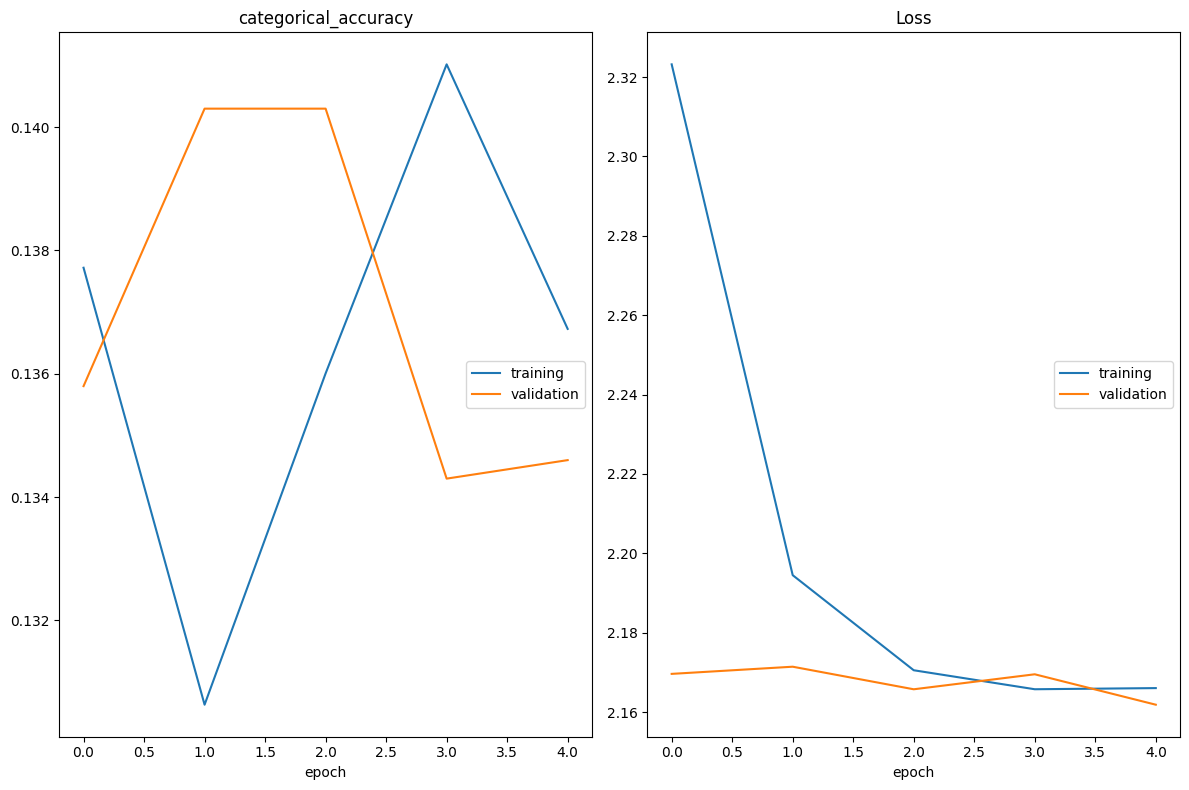

categorical_accuracy
	training         	 (min:    0.131, max:    0.141, cur:    0.137)
	validation       	 (min:    0.134, max:    0.140, cur:    0.135)
Loss
	training         	 (min:    2.166, max:    2.323, cur:    2.166)
	validation       	 (min:    2.162, max:    2.171, cur:    2.162)

Epoch 5: val_categorical_accuracy did not improve from 0.14030
250/250 [==============================] - 151s 602ms/step - loss: 2.1661 - categorical_accuracy: 0.1367 - val_loss: 2.1619 - val_categorical_accuracy: 0.1346 - lr: 5.0000e-04
Epoch 6/450
241/250 [===========================>..] - ETA: 4s - loss: 2.1651 - categorical_accuracy: 0.1368

KeyboardInterrupt: 

In [15]:
%%time

EPOCHS = 450
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=250,
    validation_steps=100,
    validation_data=validation_generator,
    callbacks=[plot_progress, effic_checkpoint, stopper, reduce_lr],
    verbose = True)

In [16]:
#Проверка текущих результатов:
model.evaluate(validation_generator)

101/101 [==============================] - 23s 220ms/step - loss: 2.1578 - categorical_accuracy: 0.1517


[2.157806634902954, 0.15169382095336914]

Детальнее посмотрим на результаты нашей модели. Начнем с того, что выведем предсказание по случайному батчу из валидационного сета:

In [17]:
#Для этого напишем функцию, выведем несколько изображений и их предсказания, а также правильные ярлыки на экран:
def show_images_preds(images, labels, predicted_labels=None):
    names = dict((v,k) for k,v in train_generator.class_indices.items()) #подтянем названия классов по их нумерации в датагене
    plt.figure(figsize=(10,8))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    #Выведем 9 изображений по 3 в каждом ряду:
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = images[i]
        #Нормализация цвета для текущего изображения:
        img = ((img-img.min()) / (img.max()- img.min())) * 255
        img = Image.fromarray(img.astype(np.uint8))
        plt.imshow(img)
        #Настройка отображения ярлыков
        if predicted_labels is not None:
            real_label = labels[i].argmax()
            title_obj = plt.title(f"Real: {names[real_label]}. Pred: {names[predicted_labels[i]]}")
            #Если предсказанный ярлык не совпадает с фактическим, цвет текста поменяем на красный:
            if real_label != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {names[labels[i]]}")

4/4 [==============================] - 3s 210ms/step


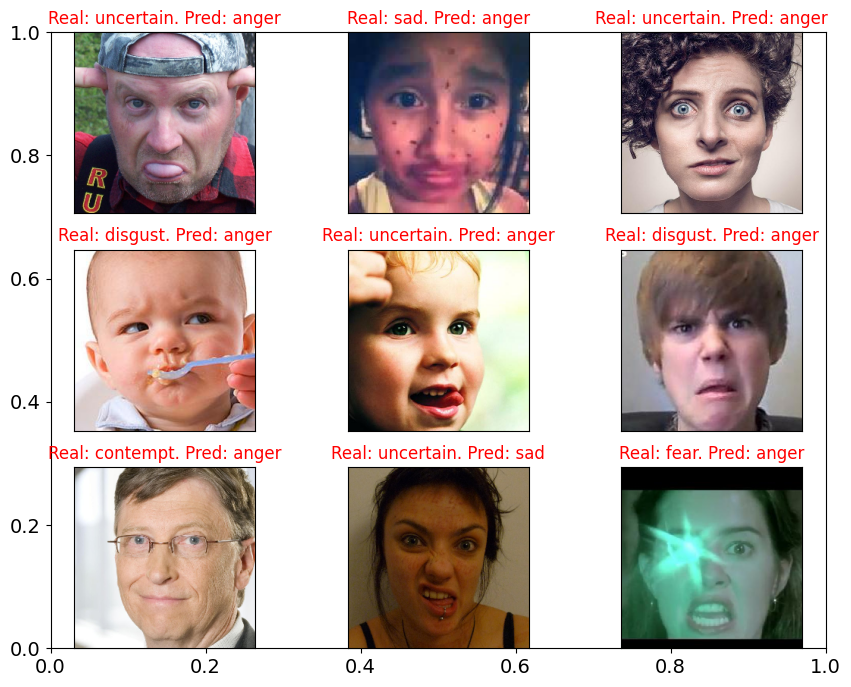

In [18]:
#Опробуем на случайном батче
sample_validation_images, sample_validation_labels = validation_generator[10]
predicted = model.predict(sample_validation_images).argmax(axis=1)
show_images_preds(sample_validation_images, sample_validation_labels, predicted)

In [19]:
# Также выведем так называемую матрицу ошибок, чтобы детальнее оценить масштабы бедствия/успеха:
preds = model.predict(validation_generator)
y_pred = np.argmax(preds , axis = 1 )
y_test = np.array(validation_generator.labels)

101/101 [==============================] - 22s 215ms/step


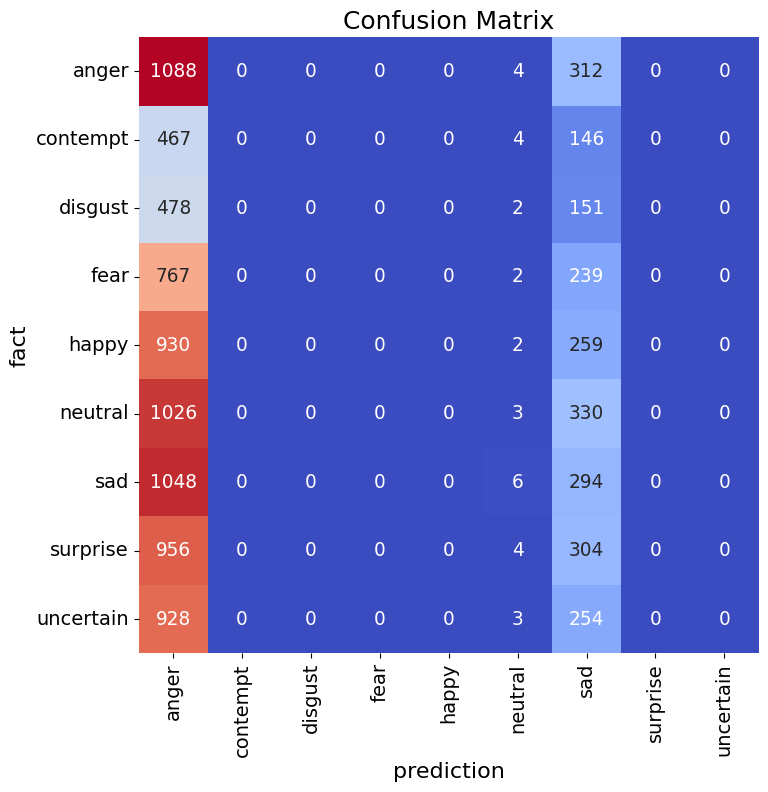

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
#Функция для отображения
def show_conf_matrix(y_test, y_pred, subset=None, cmap = "coolwarm", figsize = (8,8)):
    if subset is not None:
        cm_data = confusion_matrix(y_test , y_pred, labels=subset)
        names = dict((v,k) for k,v in train_generator.class_indices.items())
        cm_labels = [names[i] for i in subset]
    else:
        cm_labels = list(train_generator.class_indices.keys())
        cm_data = confusion_matrix(y_test , y_pred)
    
    cm = pd.DataFrame(cm_data, columns=cm_labels, index = cm_labels)
    cm.index.name = 'fact'
    cm.columns.name = 'prediction'
    plt.figure(figsize = figsize)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xlabel('fact', fontsize=16)
    plt.ylabel('prediction', fontsize=16)
    plt.title('Confusion Matrix', fontsize = 18)
    ax = sns.heatmap(cm, cbar=False, cmap = cmap, annot=True, fmt='g', cbar_kws={'label': 'Scale'}, annot_kws={"size":40 / np.sqrt(len(cm))})
    
show_conf_matrix(y_test, y_pred)

In [23]:
#Наконец, посмотрим на classification report по модели:
names = list(train_generator.class_indices.keys())
print(classification_report(y_test, y_pred, target_names=names))

              precision    recall  f1-score   support

       anger       0.14      0.77      0.24      1404
    contempt       0.00      0.00      0.00       617
     disgust       0.00      0.00      0.00       631
        fear       0.00      0.00      0.00      1008
       happy       0.00      0.00      0.00      1191
     neutral       0.10      0.00      0.00      1359
         sad       0.13      0.22      0.16      1348
    surprise       0.00      0.00      0.00      1264
   uncertain       0.00      0.00      0.00      1185

    accuracy                           0.14     10007
   macro avg       0.04      0.11      0.05     10007
weighted avg       0.05      0.14      0.06     10007



/home/nette/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/nette/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/nette/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [24]:
# Fine tuning
# посмотрим на исходную архитектуру модели
for i, layer in enumerate(model.layers[0].layers):
    print(i, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block1b_project_conv
10 block1b_project_bn
11 block1b_project_activation
12 block1b_drop
13 block1b_add
14 block2a_expand_conv
15 block2a_expand_bn
16 block2a_expand_activation
17 block2a_project_conv
18 block2a_project_bn
19 block2b_expand_conv
20 block2b_expand_bn
21 block2b_expand_activation
22 block2b_project_conv
23 block2b_project_bn
24 block2b_drop
25 block2b_add
26 block2c_expand_conv
27 block2c_expand_bn
28 block2c_expand_activation
29 block2c_project_conv
30 block2c_project_bn
31 block2c_drop
32 block2c_add
33 block3a_expand_conv
34 block3a_expand_bn
35 block3a_expand_activation
36 block3a_project_conv
37 block3a_project_bn
38 block3b_expand_conv
39 block3b_expand_bn
40 block3b_expand_activation
41 block3b_project_conv
42 block3b_project_bn
43 block3b_drop
44 block3b_add
45 block3c_expand_conv
46 block3c_expand_bn
47 block3c_

Модель работает хуже изначально выбранного resnet_v2.